In [2]:
import scipy.io #initializes libraries

import time
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
mat = scipy.io.loadmat('../data/Oxford/Oxford_Battery_Degradation_Dataset_1.mat') #reads dataset

In [4]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

In [5]:
input_data = [
    [[], []],  # cell 1, [0, 1, 2, ... 82], [730, 729, ... value for q, ... , 530]
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []],
    [[], []]
]

CELL_SIZE = [83, 78, 82, 52, 49, 51, 82, 82] # number of the cycles for each cell

In [6]:
for i in range(0, 8): #breaks down dataset to return the values that we need
    cell_num = "Cell{}".format(i + 1)
    for j in range(0, CELL_SIZE[i]):
        cyc_num = "cyc{:04d}".format(j * 100) # if j=47, cyc_num = "cyc4700"; if j=1, cyc_num = "cyc0100"
        try:
            curr = mat[cell_num][0][cyc_num][0][0]["C1ch"][0][0]['q'][0][-1][0]
        except ValueError:
            curr = float("NaN")
        input_data[i][0].append(j)
        input_data[i][1].append(curr)

In [7]:
train_x = []
train_y = []
#test_x is a 2d dataset
test_x = [ 
    [],
    [],
    [],
    []
]
#test_y is a 2d dataset
test_y = [
    [],
    [],
    [],
    []
]

In [8]:
for i in range(0, 8):

    df_input = pd.DataFrame(input_data[i]).transpose()
    df_input = df_input.rename(columns={0: "cycle", 1: "q_value"})
    df_input['interpolate_time'] = df_input['q_value'].interpolate(option='time') #time interpolate preprocessing of cells 1 to 8
    df_input['soh'] = df_input['interpolate_time'] / 740

    df_input = df_input.drop("cycle", axis=1)
    df_input = df_input.drop("q_value", axis=1)
    df_input = df_input.drop("interpolate_time", axis=1)

    # normalisation
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df_input.values)
    label_sc.fit(df_input.iloc[:, 0].values.reshape(-1, 1)) #MinMaxScaler preprocessing of cells 1 to 8

    # windowing of time series
    lookback = 10 #data windowing value
    inputs = np.zeros((len(data) - lookback, lookback, df_input.shape[1]))
    labels = np.zeros(len(data) - lookback)

    for j in range(lookback, len(data)):
        inputs[j - lookback] = data[j - lookback:j]
        labels[j - lookback] = data[j, 0]
    inputs = inputs.reshape(-1, lookback, df_input.shape[1])
    labels = labels.reshape(-1, 1)

    if (i < 4):
        if len(train_x) == 0:
            train_x = inputs[:]
            train_y = labels[:]
        else:
            train_x = np.concatenate((train_x, inputs[:]))
            train_y = np.concatenate((train_y, labels[:]))
    else:
        test_x[i - 4] = inputs
        test_y[i - 4] = labels

In [9]:
np.array(train_x).shape

(255, 10, 1)

In [10]:
np.array(train_y).shape

(255, 1)

In [11]:
np.array(test_x[0]).shape # test_x = [[Cell5], [Cell6], [Cell7], [Cell8]]

(39, 10, 1)

In [12]:
np.array(test_y[0]).shape

(39, 1)

In [13]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [14]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [15]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__() 
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [16]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [17]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=100, model_type="GRU"):
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)

    print("----------------------------------------")
    print("The", model_type, "has the layers as: ")
    print(model)
    print("----------------------------------------")

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1, EPOCHS + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter,
                                                                                       len(train_loader),
                                                                                       avg_loss / counter))

        current_time = time.process_time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss / len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time - start_time)))
        epoch_times.append(current_time - start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [18]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()

    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))

    print("Evaluation Time: {}".format(str(time.process_time() - start_time)))
    MAE = 0
    RMSE = 0
    for i in range(len(outputs)):
        MAE += np.mean(abs(outputs[i] - targets[i])) / len(outputs)
        RMSE += np.mean((outputs[i] - targets[i]) ** 2) / len(outputs)
    RMSE = math.sqrt(RMSE)
    print("MAE: {}".format(MAE))
    print("RMSE: {}".format(RMSE))
    return outputs, targets, MAE, RMSE

In [19]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")
lstm_model = train(train_loader, lr, model_type="LSTM")

----------------------------------------
The GRU has the layers as: 
GRUNet(
  (gru): GRU(1, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)
----------------------------------------
Starting Training of GRU model
Epoch 1......Step: 1/7....... Average Loss for Epoch: 0.09475073963403702
Epoch 1......Step: 2/7....... Average Loss for Epoch: 0.0884423479437828
Epoch 1......Step: 3/7....... Average Loss for Epoch: 0.08462222417195638
Epoch 1......Step: 4/7....... Average Loss for Epoch: 0.0753876380622387
Epoch 1......Step: 5/7....... Average Loss for Epoch: 0.069479800760746
Epoch 1......Step: 6/7....... Average Loss for Epoch: 0.06562752400835355
Epoch 1......Step: 7/7....... Average Loss for Epoch: 0.060775416770151684
Epoch 1/100 Done, Total Loss: 0.060775416770151684
Total Time Elapsed: 1.96875 seconds
Epoch 2......Step: 1/7....... Average Loss for Epoch: 0.03816186636686325
Epoch 2......Step: 2/7....... A

In [21]:
torch.save(gru_model.state_dict(), "../saved_models/gru_model.pt")
torch.save(lstm_model.state_dict(), "../saved_models/lstm_model.pt")

GRU Evaluation for Cell 5
Evaluation Time: 0.125
MAE: 0.001097973421936006
RMSE: 0.0014144689438226733


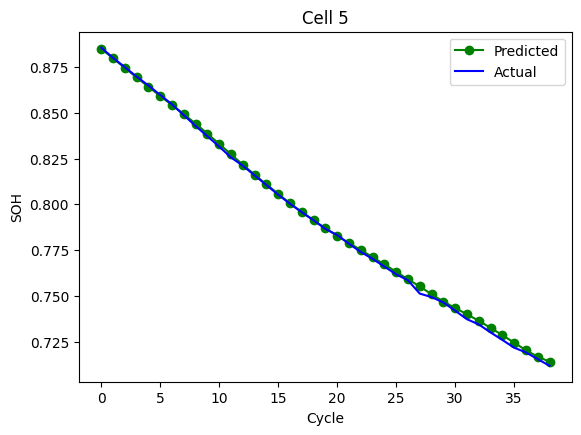

GRU Evaluation for Cell 6
Evaluation Time: 0.125
MAE: 0.002049649898177415
RMSE: 0.004489099973708877


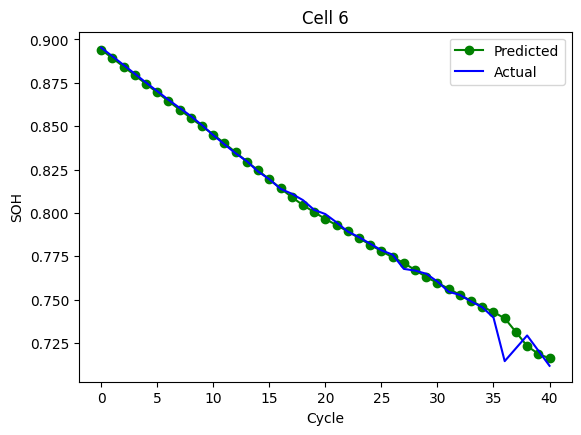

GRU Evaluation for Cell 7
Evaluation Time: 0.21875
MAE: 0.003532017824061153
RMSE: 0.0038228687906383847


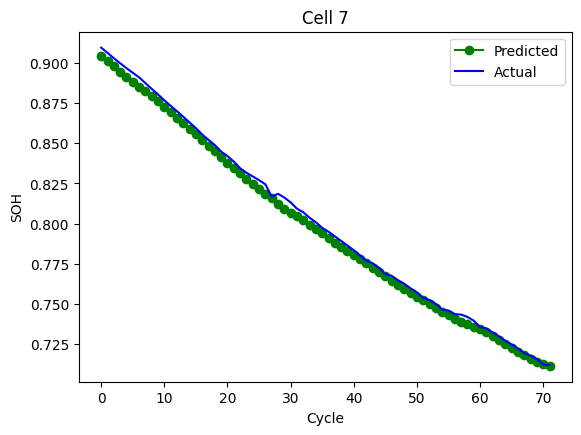

GRU Evaluation for Cell 8
Evaluation Time: 0.125
MAE: 0.0035975592426907843
RMSE: 0.003988878397955047


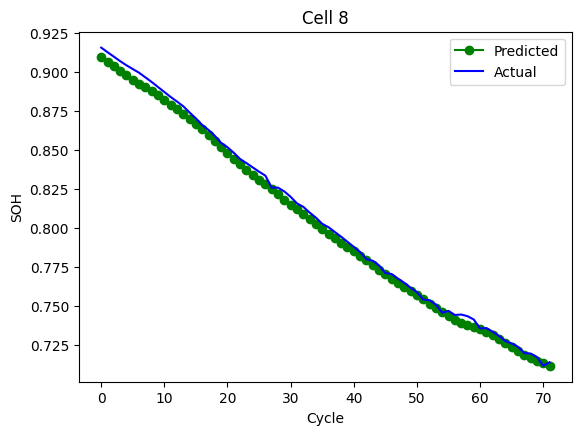

In [22]:
for i in range(0, 4): #plot both graphs
    print("GRU Evaluation for Cell {}".format(i + 5))
    gru_outputs, targets, gru_MAE, gru_RMSE = evaluate(gru_model, test_x[i], test_y[i], label_sc)
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
    plt.plot(targets[0][-100:], color="b", label="Actual")
    plt.xlabel('Cycle')
    plt.ylabel('SOH')
    plt.title("Cell {}".format(i + 5))
    plt.legend()
    plt.show()

# MAE and RMSE
# predicted curve
# performance, numerical results

LSTM Evaluation for Cell 5
Evaluation Time: 0.171875
MAE: 0.00496651159941313
RMSE: 0.0050388560470849145


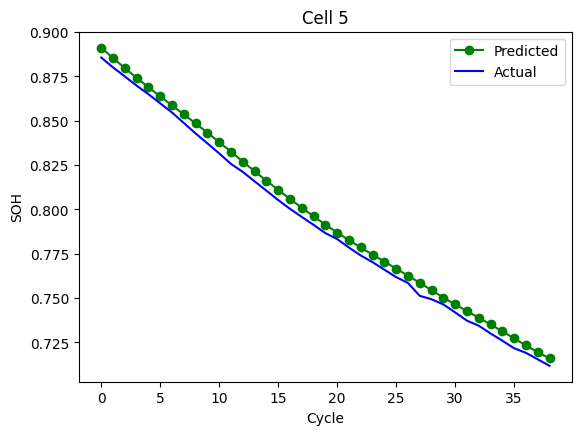

LSTM Evaluation for Cell 6
Evaluation Time: 0.203125
MAE: 0.004287902803103164
RMSE: 0.00597403010175092


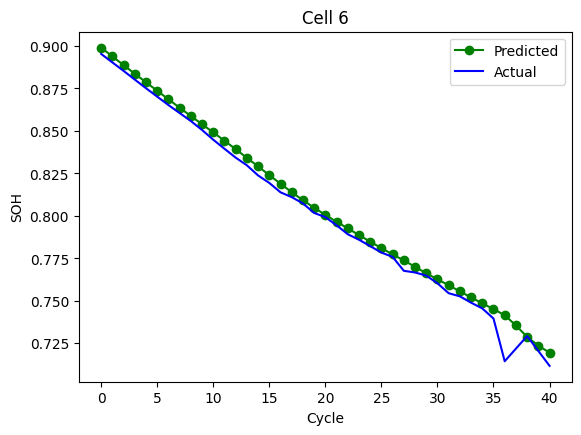

LSTM Evaluation for Cell 7
Evaluation Time: 0.28125
MAE: 0.0020694446310632253
RMSE: 0.0024049669618627953


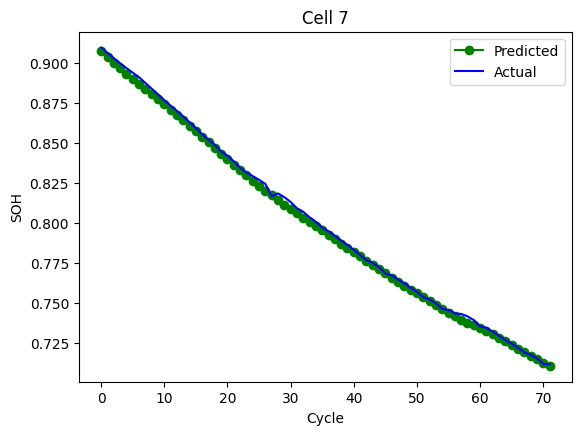

LSTM Evaluation for Cell 8
Evaluation Time: 0.21875
MAE: 0.0022970852537496245
RMSE: 0.0027899224428143744


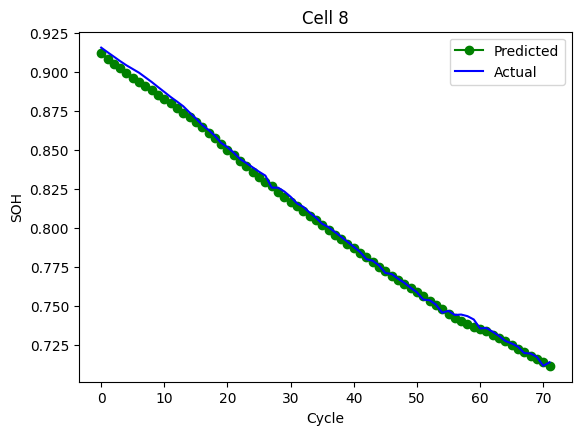

In [21]:
for i in range(0, 4):
    print("LSTM Evaluation for Cell {}".format(i + 5))
    lstm_outputs, targets, lstm_MAE, lstm_RMSE = evaluate(lstm_model, test_x[i], test_y[i], label_sc)
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(lstm_outputs[0][-100:], "-o", color="g", label="Predicted")
    plt.plot(targets[0][-100:], color="b", label="Actual")
    plt.xlabel('Cycle')
    plt.ylabel('SOH')
    plt.title("Cell {}".format(i + 5))
    plt.legend()
    plt.show()

# MAE and RMSE
# predicted curve
# performance, numerical results